<a href="https://colab.research.google.com/github/sarayukammari/ML-Projects/blob/main/Copy_of_Titanic_Survival_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [ ]:
train_data, test_data= load_titanic_data()

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train_data["Embarked"].value_counts()

,count
Embarked,
S,644
C,168
Q,77


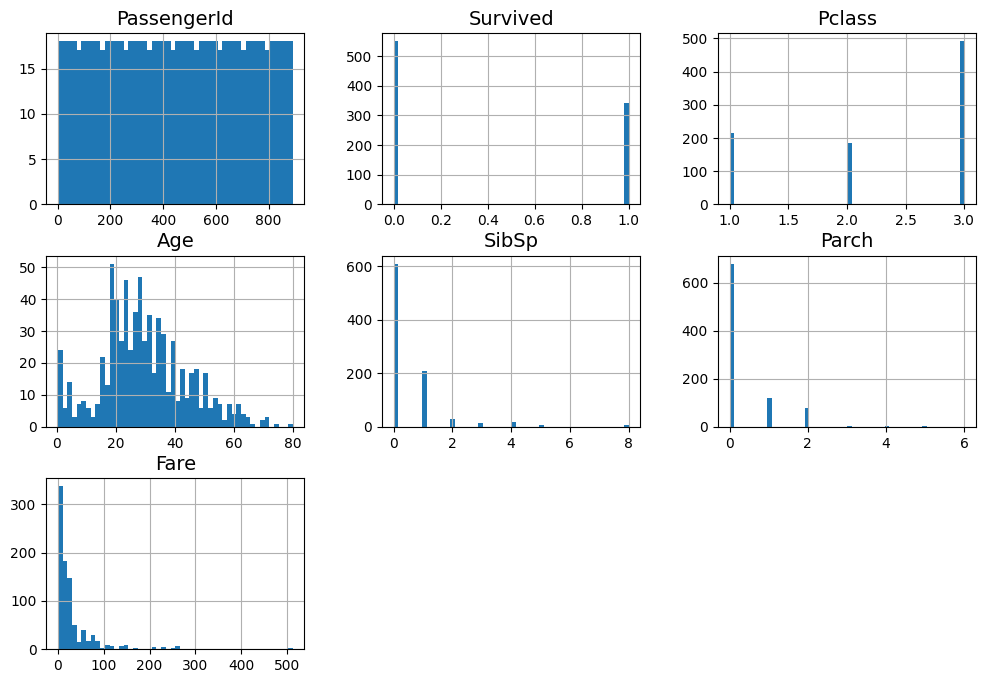

In [ ]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_data.hist(bins=50, figsize=(12, 8))

plt.show()

In [ ]:
null_rows_idx = train_data.isnull().any(axis=1)
train_data.loc[null_rows_idx].head()

In [ ]:
train_data["Family"]=train_data["Parch"]+train_data["SibSp"]
train_data["Family"].value_counts()
train_data["AgeBucket"] = train_data["Age"] // 15 * 15


In [ ]:
train_data["AgeBucket"].value_counts()
train_data["Family"].value_counts()

,count
Family,
0,537
1,161
2,102
3,29
5,22
4,15
6,12
10,7
7,6


In [ ]:
train_data["Cabin"]=train_data["Cabin"].fillna("Unknown")
train_data["Cabin"]=train_data["Cabin"].str[0]
train_data["Cabin"].value_counts()

,count
Cabin,
U,687
C,59
B,47
D,33
E,32
A,15
F,13
G,4
T,1


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
cat_pipeline = Pipeline([
        ("ordinal_encoder", OrdinalEncoder()),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ])

In [ ]:
from sklearn.compose import ColumnTransformer

num_attributes=[ "Family", "Fare"]
cat_attributes=["Pclass","Cabin", "Sex","AgeBucket","Embarked"]

main_pipeline= ColumnTransformer([
    ("nums", num_pipeline, num_attributes),
    ("cat", cat_pipeline, cat_attributes)
])

In [ ]:
X_train = main_pipeline.fit_transform(train_data)
Y_train= train_data["Survived"]


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
forest_clf= RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [ ]:
test_data["Family"]=test_data["Parch"]+test_data["SibSp"]

test_data["AgeBucket"] = test_data["Age"] // 15 * 15
test_data["Cabin"]=test_data["Cabin"].fillna("Unknown")
test_data["Cabin"]=test_data["Cabin"].str[0]


In [ ]:

X_test= main_pipeline.transform(test_data)
Y_pred= forest_clf.predict(X_test)

In [ ]:

from sklearn.model_selection import cross_val_score
scores= cross_val_score(forest_clf, X_train, Y_train, cv=10)
print(scores.mean)

<built-in method mean of numpy.ndarray object at 0x7d4a5ab0b450>


In [ ]:
print(scores.mean())

0.8159925093632958


In [ ]:
from sklearn.svm import SVC

svc_model =SVC(gamma="auto")
svc_model.fit(X_train, Y_train)

SVC(gamma='auto')

In [ ]:
Y_predic1= svc_model.predict(X_test)
scores1= cross_val_score(svc_model, X_train, Y_train, cv=10)
print(scores1.mean())

0.8058426966292135
